Part of the code is based on the Madry Lab's robustness toolkit and Google DeepDream. You can check out more here https://github.com/MadryLab
and here https://distill.pub/2017/feature-visualization/


**Note:** To speed up the execution of the experiments, we recommend using GPU acceleration. If you are running the notebook on Colab, select GPU as your runtime type as follows: Runtime → Change runtime type → Hardware accelerator → GPU → Save.

In [1]:
from matplotlib import pyplot as plt
import torch
from tqdm import tqdm_notebook as tqdm
import numpy as np
import torchvision.models as models
import cv2
import torchvision.transforms as transforms
cuda_available = torch.cuda.is_available()

In [2]:
import requests
def download(url, fn=None):
  if fn is None:
    fn = url.split('/')[-1]
  r = requests.get(url)
  if r.status_code == 200:
      open(fn, 'wb').write(r.content)
      print("{} downloaded: {:.2f} KB".format(fn, len(r.content)/1024.))
  else:
      print("url not found:", url)

Download the test image and classes.

In [3]:
download("https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt", "imagenet_classes.txt")
download("https://raw.githubusercontent.com/pytorch/hub/master/images/dog.jpg", "WelshCorgi.jpeg")


imagenet_classes.txt downloaded: 10.23 KB
WelshCorgi.jpeg downloaded: 645.88 KB




# Neural Network Inference (Problem 2)

In this exercise, you will be playing with a convolutional neural network to classify images into semantic labels. You will be working with ResNet50, a variant of the residual convolutional network architecture. We will be testing the network to classify an image into one of the 1000 ImageNet categories.

### Load ImageNet class names


In [4]:
with open('imagenet_classes.txt', 'r') as f:
  imagenet_classes = f.readlines()
  imagenet_classes_short = [x.strip().split(',')[-1] for x in imagenet_classes]

print('Imagenet classes')
for it, class_name in enumerate(imagenet_classes):
  if it == 3:
    print('...')
  elif it < 4 or it > 997:
    print('{}. {}'.format(it, class_name))

Imagenet classes
0. tench

1. goldfish

2. great white shark

...
998. ear

999. toilet tissue


## Running a randomly initialized network
We will start by using a randomly initalized ResNet50 to perform classification.

### Load a randomly initalized network (Problem 2a)

In [5]:
# Download ResNet50 from Pytorch repository
arch = 'resnet50'
model = models.__dict__[arch]()
# We set it in eval, so that batch normalization layers are not updated
model.eval();
if cuda_available:
  model.cuda()

In [ ]:
# Visualize the last layer
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

### Preparing the image for inference

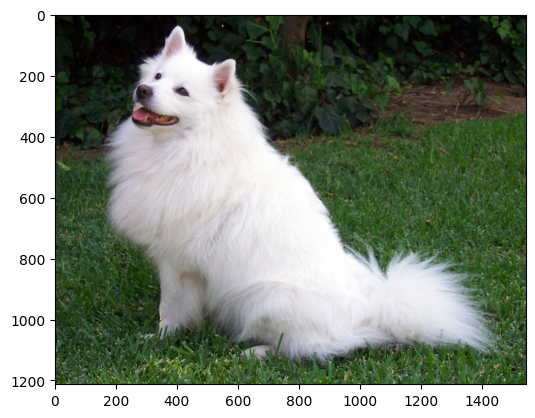

In [ ]:
# Load the image we will be playing with
img = cv2.imread('WelshCorgi.jpeg')
plt.imshow(img[:, :, ::-1])

In [ ]:
# In order to run the image through a model, we need to prepare it first.
# This includes:
# 1. Resizing the image to an appropiate size for the network.
# 2. Converting the image to a tensor - this will normalize the image in the
#    0-1 range and change the channel order.
# 3. Normalizing the image.
# 4. Puting the image in a batch. In our case, we will use a single element
#    batch.

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

def prepare_image(image_cv2, do_normalize=True):
  # Resize
  img = cv2.resize(image_cv2, (224, 224))
  img = img[:, :, ::-1].copy()
  # Convert to tensor
  tensor_img = transforms.functional.to_tensor(img)

  # Possibly normalize
  if do_normalize:
    tensor_img = normalize(tensor_img)
  # Put image in a batch
  batch_tensor_img = torch.unsqueeze(tensor_img, 0)

  # Put the image on the GPU
  if cuda_available:
    batch_tensor_img = batch_tensor_img.cuda()
  return batch_tensor_img


def UnNormalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]):
  std_arr = torch.tensor(std)[:, None, None]
  mean_arr = torch.tensor(mean)[:, None, None]
  def func(img):
    img = img.clone()
    img *= std_arr
    img += mean_arr
    return img
  return func
unnormalize = UnNormalize()

def obtain_image(tensor_img, do_normalize=True):
  tensor_img = tensor_img.cpu()
  if do_normalize:
    tensor_img = unnormalize(tensor_img)
  img = transforms.functional.to_pil_image((tensor_img.data))
  return img

### Classifying the image (Problem 2b)

This architecture outputs a vector of 1000 elements, that correspond to the class logits: each of the class probabilities before doing a softmax.

In [ ]:
# Prepare the image
batch_normalized_img = prepare_image(img)
# Run it through the network
output = model(batch_normalized_img)

Let's visualize the top classes

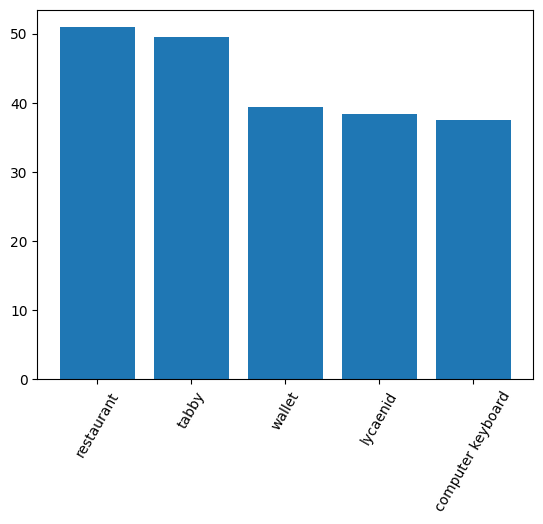

In [ ]:
def plot_top_classes(values, top_k=5):
  sorted_classes = np.argsort(-values)
  class_ids = sorted_classes[:top_k]
  class_names = [imagenet_classes_short[it] for it in list(class_ids)]
  class_values = values[class_ids]
  plt.bar(class_names, class_values)
  plt.xticks(rotation=60)


plot_top_classes(output[0,:].data.cpu().numpy())

### Load and run a pre-trained network (Problem 2c)

Unsurprisingly, the network predictions above have nothing to do with the image, since the network was intialized from scratch. Instead, we will initialize the network with pre-trained weights (from a neural network that has been trained on the ImageNet dataset).

In [ ]:
arch = 'resnet50'
model = models.__dict__[arch](pretrained=True)
model.eval();
model.cuda();

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 161MB/s]


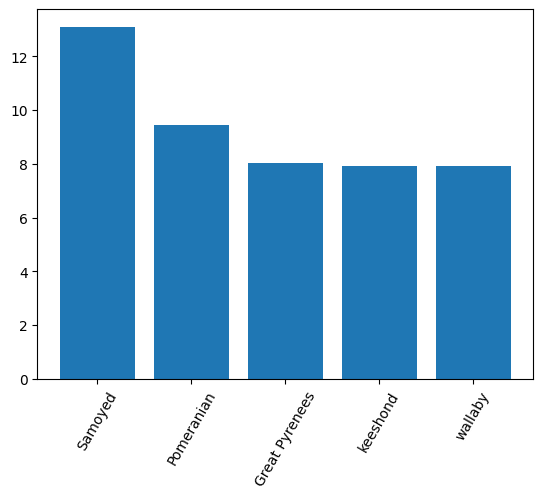

In [ ]:
output = model(batch_normalized_img.cuda())
plot_top_classes(output[0,:].data.cpu().numpy())

The top predictions seem to make much more sense now. But it is not clear how to interpret the logits (the raw output scalars). Please normalize the logits into the probability range using the `torch.nn.functional.softmax` function (TODO1).  

In [ ]:
import torch.nn.functional as F

def output2prob(output):
    """Converts logits to probabilities using the softmax function."""
    prob = F.softmax(output, dim=1)  # Apply softmax to get probabilities
    return prob




Now rerun the network, passing the output through our `output2prob` function:

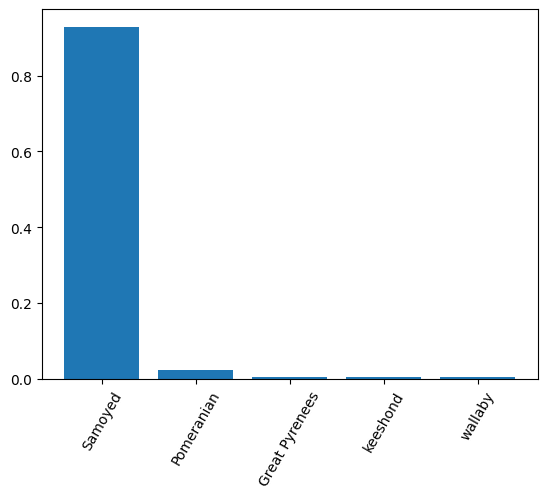

In [ ]:
output = model(batch_normalized_img.cuda())
prob = output2prob(output)
plot_top_classes(prob[0,:].data.cpu().numpy())